In [1]:
import pandas as pd
import numpy as np
import scipy.optimize
import datetime

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

### Observation

Read cherry blossoms dataset for Tidal Basin, Washington DC. Records are available at https://cherryblossomwatch.com

In [3]:
cherry_dc = pd.read_hdf('./cherry_dc.h5')

In [4]:
cherry_dc.tail()

Extension of Florets Florets Visible  \
station cultivar year                                        
DC      Yoshino  2015           2015-04-04      2015-04-01   
                 2016           2016-03-15      2016-03-13   
                 2017           2017-03-06      2017-03-01   
                 2018           2018-03-26      2018-03-15   
                 2019                  NaT             NaT   

                      Green Color In Buds Peak Bloom Peduncle Elongation  \
station cultivar year                                                      
DC      Yoshino  2015          2015-03-18 2015-04-10          2015-04-06   
                 2016          2016-03-08 2016-03-25          2016-03-17   
                 2017          2017-02-24 2017-03-25          2017-03-08   
                 2018          2018-02-25 2018-04-05          2018-03-29   
                 2019                 NaT 2019-04-01                 NaT   

                      Puffy White  
station cultivar year              
DC      Yoshino  2015  2015-04-08  
                 2016  2016-03-22  
                 2017  2017-03-22  
                 2018  2018-04-01  
                 2019         NaT

We only use **Peak Bloom** dates of **Yoshino** cherry in the **DC** area.

In [5]:
obs = cherry_dc.loc['DC', 'Yoshino']['Peak Bloom']

In [6]:
obs

year
1921   1921-03-20
1922   1922-04-07
1923   1923-04-09
1924   1924-04-13
1925   1925-03-27
          ...    
2015   2015-04-10
2016   2016-03-25
2017   2017-03-25
2018   2018-04-05
2019   2019-04-01
Name: Peak Bloom, Length: 99, dtype: datetime64[ns]

### Weather

Read weather dataset. Hourly data from weather stations are available at https://www7.ncdc.noaa.gov/CDO/cdopoemain.cmd?datasetabbv=DS3505

Stations codes
- 724050: Reagan National Airport
- 727930: Seattle-Tacoma International Airport

In [7]:
usa_ds3505_dc = pd.read_hdf('./usa_ds3505_dc.h5')

In [8]:
usa_ds3505_dc.head()

tavg
station timestamp                      
724050  1936-09-01 07:00:00-04:00  15.7
        1936-09-01 08:00:00-04:00  18.0
        1936-09-01 09:00:00-04:00  17.4
        1936-09-01 10:00:00-04:00  23.5
        1936-09-01 11:00:00-04:00  25.2

Weather records are originally in hourly interval and we want to convert them into daily interval for faster processing in this lab exercise. **724050** is the station code for Reagan National Airport which is located a few miles away from Tidal Basin, Washington DC.

In [9]:
met = usa_ds3505_dc.loc[724050].resample('D').mean()

Remove timezone information from the weather dataset for easier manipulation in the later stage.

In [10]:
met.index = met.index.tz_localize(None)

In [11]:
met.tail()

,tavg
timestamp,
2019-08-27,22.483736
2019-08-28,23.287964
2019-08-29,24.850556
2019-08-30,24.827778
2019-08-31,26.747667


### Growing Degree Days Model (GDD)

The Growing Degree Days (GDD) is one of the most widely used models to describe a linear growth rate dependent on temperature forcing above a certain base temperature. When the weather records are limited to daily time scale, GDD often interpolates diurnal temperature from daily maximum and minimum temperatures, resulting into some variants of the method. We used growing degree hours (GDH) with hourly records to avoid such interpolation, but still described its parameters in daily scale for comparison with existing model parameters.

$$
\begin{aligned}
\Delta_h & = \begin{cases}
  \frac{1}{24} (T_h - T_b) & \text{if } T_h > T_b \\
  0 & \text{otherwise}
\end{cases} \\
\sum_{h=H_s}^{\hat{H}-1} \Delta_h & < R_d \leq \sum_{h=H_s}^{\hat{H}} \Delta_h
\end{aligned}
$$

#### Prepare weather data

Flowering for spring in the current year is a response to temperature changes during the past winter. Here we assume thermal accumulation for GDD model begins on the first day of the year.

In [12]:
def start_date(year):
    return datetime.date(year, 1, 1)

In [13]:
start_date(2019)

datetime.date(2019, 1, 1)

The end date of model simulation could be any date later than flowering dates which often occur during March or April. Here we decide to use May 31th.

In [14]:
def end_date(year):
    return datetime.date(year, 5, 31)

In [15]:
end_date(2019)

datetime.date(2019, 5, 31)

Now we can make a slice of weather data needed for one year of model simulation.

In [16]:
Th = met[start_date(2019):end_date(2019)].tavg
Th.head()

timestamp
2019-01-01    13.659202
2019-01-02     7.553056
2019-01-03     8.241111
2019-01-04     6.356821
2019-01-05     9.615425
Freq: D, Name: tavg, dtype: float64

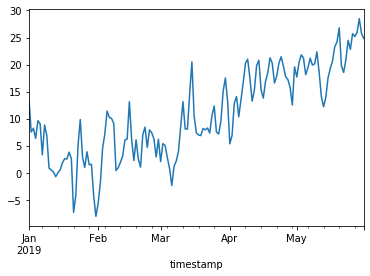

In [17]:
Th.plot()

#### Calculate thermal unit

In [18]:
def gdd(Th, Tb):
    return (Th - Tb).clip(lower=0).cumsum() #/ 24

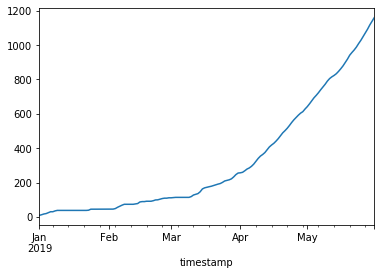

In [19]:
gdd(Th, 4).plot()

#### Match the requirement

`match` function finds the date when the cumulative thermal degree `D` reaches the thermal requirement `R`.

In [20]:
def match(D, R, ascending=True):
    D, R = (D, R) if ascending else (-D, -R)
    i = D.searchsorted(R)
    try:
        return D.index[i]
    except:
        return pd.NaT

In [21]:
match(gdd(Th, 4), 200)

Timestamp('2019-03-24 00:00:00', freq='D')

For example, GDD requirement of 200 for base temperature 4 was met in the late-March this year.

In [22]:
def plot_match(D, R, ascending=True):
    m = match(D, R, ascending)
    D.plot()
    plt.axvline(m, ls=':')
    plt.axhline(R, ls=':')
    return m

Timestamp('2019-03-24 00:00:00', freq='D')

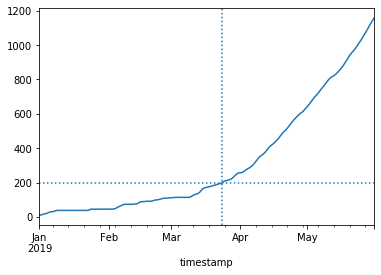

In [23]:
plot_match(gdd(Th, 4), 200)

#### GDD estimation in one function

Let's put all in a function for predicting phenology based on GDD accumulation.

In [24]:
def gdd_estimate(met, year, params, plot=False):
    Tb, Rd = params
    Th = met[start_date(year):end_date(year)].tavg
    D = gdd(Th, Tb)
    return match(D, Rd)

Our initial guess for 2019 cherry blossom is about a week off to what actually was.

In [25]:
gdd_params = (4, 300)

In [26]:
gdd_estimate(met, 2019, gdd_params)

Timestamp('2019-04-07 00:00:00', freq='D')

In [27]:
obs[2019] - _

Timedelta('-6 days +00:00:00')

#### Residual calculation

Let's make a function for calculating such difference or 'residual' which will be used in model parameterization.

In [28]:
def julian(t, year):
    #return int(t.strftime('%j'))
    return (t.year - year)*365 + float(t.strftime('%j')) + t.hour/24. + t.minute/(24*60.) + t.second/(24*60*60.)

def residual(met, obs, year, estimate, params):
    try:
        e = julian(estimate(met, year, params), year)
        o = julian(obs[year], year)
        return o - e
    except:
        return 365. # np.inf

In [29]:
residual(met, obs, 2019, gdd_estimate, gdd_params)

-6.0

It will be handy to have a more general function to calculate residuals over multiple years of prediction.

In [30]:
def residuals(met, obs, years, estimate, params):
    return np.array([residual(met, obs, y, estimate, params) for y in years])

We will use 30 years of data from 1980 to 2009 for calibration.

In [31]:
years = range(1980, 2009+1)

In [32]:
r = residuals(met, obs, years, gdd_estimate, gdd_params)
r

array([ -4.,   2., -12.,  -3., -12.,  -4.,  -6., -20., -11., -16.,  -1.,
        -5.,  -7., -10., -11.,  -6., -12.,  -4.,  -5.,  -2.,  -9.,  -9.,
         2., -17., -15.,  -4.,  -4.,  -2.,  -3., -16.])

And let's keep data from 2010 to 2019 for testing later.

In [33]:
testing_years = range(2010, 2019+1)

#### RMSE (Root-Mean-Square Error)

In [34]:
def rmse(r):
    return np.sqrt((r**2).mean())

In [35]:
rmse(r)

9.395034149308168

#### EF (Model Efficiency)

First, make a helper function to get observation data from multiple years.

In [36]:
def observes(years):
    return np.array([julian(obs[y], y) for y in years])

Similarly, let's make a helper function for running multiple years of estimation. This will be used later in the notebook.

In [37]:
def estimates(met, years, estimate, params):
    return np.array([julian(estimate(met, y, params), y) for y in years])

In [38]:
estimates(met, years, gdd_estimate, (4, 300))

array([101.,  91., 109., 100., 106., 101.,  98., 107., 102., 104.,  75.,
        93., 105., 111., 106.,  98., 107.,  89.,  91.,  97.,  86., 105.,
        90., 109., 106., 103.,  93.,  93.,  92., 107.])

In [39]:
def ef(r, o):
    do = o - o.mean()
    return 1 - np.sum(r**2) / np.sum(do**2)

In [40]:
o = observes(years)
o

array([ 97.,  93.,  97.,  97.,  94.,  97.,  92.,  87.,  91.,  88.,  74.,
        88.,  98., 101.,  95.,  92.,  95.,  85.,  86.,  95.,  77.,  96.,
        92.,  92.,  91.,  99.,  89.,  91.,  89.,  91.])

Here is the model efficiency (EF) for GDD from our initial guess without parameter optimization. How would you interprete the model performance based on RMSE and EF?

In [41]:
ef(r, o)

-1.5885496431946295

## Model Parameterization

In [42]:
def cost(params, *args):
    return rmse(residuals(*args, params))

In [43]:
cost((4, 300), met, obs, years, gdd_estimate)

9.395034149308168

#### Simplex Method (a.k.a., Nelder-Mead method)

In [44]:
def calibrate_nm(met, obs, years, estimate, func, params0):
    return scipy.optimize.minimize(
        fun=func,
        x0=params0,
        args=(met, obs, years, estimate),
        method='Nelder-Mead',
        options={
            'disp': True,
        }
    )
res = calibrate_nm(met, obs, years, gdd_estimate, cost, (4, 300))
res

Optimization terminated successfully.
         Current function value: 5.790797
         Iterations: 29
         Function evaluations: 87


 final_simplex: (array([[  4.08066406, 238.41796875],
       [  4.080666  , 238.41787755],
       [  4.08066457, 238.41798976]]), array([5.7907973, 5.7907973, 5.7907973]))
           fun: 5.790797296861058
       message: 'Optimization terminated successfully.'
          nfev: 87
           nit: 29
        status: 0
       success: True
             x: array([  4.08066406, 238.41796875])

In [45]:
gdd_params_nm = tuple(res.x)

In [46]:
rmse(residuals(met, obs, years, gdd_estimate, gdd_params_nm))

5.790797296861058

In [47]:
ef(residuals(met, obs, years, gdd_estimate, gdd_params_nm), observes(years))

0.016585747336179235

#### Differential Evolution

In [48]:
def calibrate_de(met, obs, years, estimate, func, bounds):
    return scipy.optimize.differential_evolution(
        func=func,
        bounds=bounds,
        args=(met, obs, years, estimate),
        disp=True,
    )
res = calibrate_de(met, obs, years, gdd_estimate, cost, ((0, 10), (0, 1000)))
gdd_params_de = tuple(res.x)

differential_evolution step 1: f(x)= 6.10737
differential_evolution step 2: f(x)= 6.02495
differential_evolution step 3: f(x)= 6.02495
differential_evolution step 4: f(x)= 5.98052
differential_evolution step 5: f(x)= 5.73004
differential_evolution step 6: f(x)= 5.46199
differential_evolution step 7: f(x)= 5.46199
differential_evolution step 8: f(x)= 5.46199
differential_evolution step 9: f(x)= 5.39753
differential_evolution step 10: f(x)= 5.39753
differential_evolution step 11: f(x)= 5.39753
differential_evolution step 12: f(x)= 5.39753
differential_evolution step 13: f(x)= 5.36346
differential_evolution step 14: f(x)= 5.35724
differential_evolution step 15: f(x)= 5.35724
differential_evolution step 16: f(x)= 5.35724
differential_evolution step 17: f(x)= 5.28835
differential_evolution step 18: f(x)= 5.28835
differential_evolution step 19: f(x)= 5.28835
differential_evolution step 20: f(x)= 5.28835
differential_evolution step 21: f(x)= 5.28835
differential_evolution step 22: f(x)= 5.288

In [49]:
ef(residuals(met, obs, years, gdd_estimate, gdd_params_de), observes(years))

0.17983642347420914

#### Brute-force (Generally, brute-force optimization can take a long time to complete so be prepared)

In [50]:
def calibrate_bf(met, obs, years, estimate, func, ranges):
    return scipy.optimize.brute(
        func=func,
        ranges=ranges,
        args=(met, obs, years, estimate),
        full_output=True,
        finish=scipy.optimize.fmin,
        disp=True,
    )
res = calibrate_bf(met, obs, years, gdd_estimate, cost, (slice(0, 10, 1), slice(0, 1000, 50)))
gdd_params_bf = tuple(res[0])

Optimization terminated successfully.
         Current function value: 5.534739
         Iterations: 25
         Function evaluations: 76


In [51]:
gdd_params_bf

(5.25, 190.0)

In [52]:
ef(residuals(met, obs, years, gdd_estimate, gdd_params_bf), observes(years))

0.10163250676138047

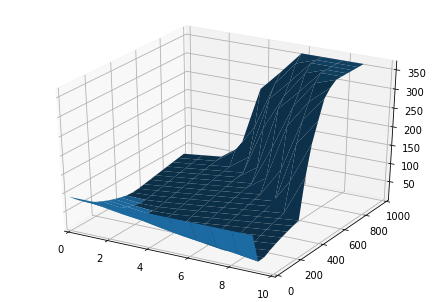

In [53]:
def plot_bf(res, xlim=None, ylim=None):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(res[2][0], res[2][1], res[3])
    if xlim is not None:
        ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)
    plt.show()
plot_bf(res, xlim=(0, 10), ylim=(0, 1000))

### Plotting the results

In [54]:
def plot(met, years, estimate, params):
    o = observes(years)
    e = estimates(met, years, estimate, params)
    return pd.DataFrame(
        data={'obs': o, 'est': e},
        index=years,
    ).plot()

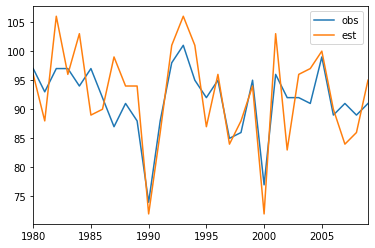

In [55]:
plot(met, years, gdd_estimate, gdd_params_de)

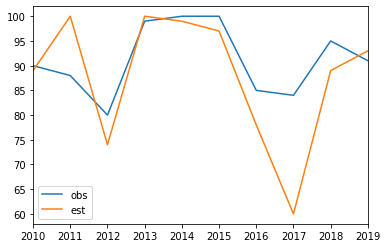

In [56]:
plot(met, testing_years, gdd_estimate, gdd_params_de)

### Chilling and Forcing Model (CF)

Cesaraccio *et al.* split up dormancy break into two distinctive steps, rest and quiescence, that required the same amount of chilling and subsequent anti-chilling accumulation in the opposite direction. Later this model was extended to predict FBD coming after bud burst. The following equation represents our adaptation of this chilling and forcing (CF) model with three parameters: temperature threshold ($T_c$), chilling ($R^{\mathtt{C}}$) and forcing ($R^{\mathtt{F}}$) requirements. Unlike other forcing-only models, the starting date was implicitly set to October 1st of the previous year. Earlier dates are unlikely to impact model behavior much because the air temperature in September and before are mostly higher than the threshold ($T_c$), resulting in little or no chilling effect.

$$
\begin{aligned}
T'_h & = \begin{cases}
  T_h & \text{if } T_h \geq 0 \\
  0 & \text{otherwise}
\end{cases} \\
\Delta_h & = \frac{1}{24} (T'_h - T_c) \\
\Delta_h^{\mathtt{C}} & = \begin{cases}
  \Delta_h & \text{if } \Delta_h < 0 \\
  0 & \text{otherwise}
\end{cases} \\
\Delta_h^{\mathtt{F}} & = \begin{cases}
  \Delta_h & \text{if } \Delta_h > 0 \\
  0 & \text{otherwise}
\end{cases} \\
\sum_{h=H_s}^{\hat{H_0}-1} \Delta_h^{\mathtt{C}} & > R_d^{\mathtt{C}} \geq \sum_{h=H_s}^{\hat{H_0}} \Delta_h^{\mathtt{C}} \\
\sum_{h=\hat{H_0}}^{\hat{H}-1} \Delta_h^{\mathtt{F}} & < R_d^{\mathtt{F}} \leq \sum_{h=\hat{H_0}}^{\hat{H}} \Delta_h^{\mathtt{F}} \\
\end{aligned}
$$

As the CF model takes account of dormancy break due to chilling effect, we should take a longer period of weather data than what we used for GDD model above. We assume October 1st as a starting date of thermal accumulation for the CF model.

In [57]:
def cf_start_date(year):
    return datetime.date(year-1, 10, 1)

In [58]:
Thp = met[cf_start_date(2019):end_date(2019)].tavg.clip(lower=0)

In [59]:
def chill(Th, Tc):
    return (Th - Tc).clip(upper=0).cumsum() #/ 24

Timestamp('2019-02-20 00:00:00', freq='D')

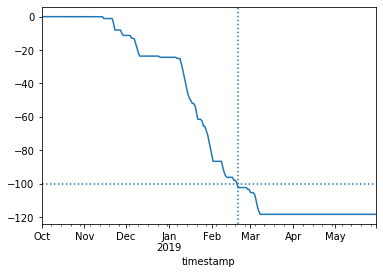

In [60]:
plot_match(chill(Thp, 4), -100, ascending=False)

In [61]:
def antichill(Th, Tc):
    return (Th - Tc).clip(lower=0).cumsum() #/ 24

Timestamp('2019-04-06 00:00:00', freq='D')

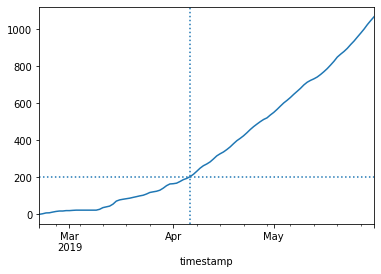

In [62]:
plot_match(antichill(Thp.loc[_:], 4), 200)

In [63]:
def cf_estimate(met, year, params):
    Tc, Rc, Rf = params
    Thp = met[cf_start_date(year):end_date(year)].tavg.clip(lower=0)
    Dc = chill(Thp, Tc)
    m = match(-Dc, -Rc)
    # force release dormancy even if chilling requirement is not fully satisfied
    if pd.isnull(m):
        m = pd.Timestamp(year, 3, 1)
    Df = antichill(Thp.loc[m:], Tc)
    return match(Df, Rf)

In [64]:
cf_params = (4, -100, 200)

In [65]:
cf_estimate(met, 2019, cf_params)

Timestamp('2019-04-06 00:00:00', freq='D')

In [66]:
obs[2019]

Timestamp('2019-04-01 00:00:00')

In [67]:
res = calibrate_nm(met, obs, years, cf_estimate, cost, cf_params)
cf_params_nm = tuple(res.x)
res

Optimization terminated successfully.
         Current function value: 5.170429
         Iterations: 32
         Function evaluations: 105


 final_simplex: (array([[   4.21610852, -105.49364849,  193.06497206],
       [   4.21610735, -105.49370077,  193.06506912],
       [   4.21610843, -105.49365039,  193.0650364 ],
       [   4.21610937, -105.49367427,  193.06498719]]), array([5.17042874, 5.17042874, 5.17042874, 5.17042874]))
           fun: 5.170428737864331
       message: 'Optimization terminated successfully.'
          nfev: 105
           nit: 32
        status: 0
       success: True
             x: array([   4.21610852, -105.49364849,  193.06497206])

In [68]:
res = calibrate_de(met, obs, years, cf_estimate, cost, ((0, 10), (-200, 0), (0, 1000)))
cf_params_de = tuple(res.x)
res

differential_evolution step 1: f(x)= 5.03653
differential_evolution step 2: f(x)= 4.37417
differential_evolution step 3: f(x)= 4.05791
differential_evolution step 4: f(x)= 4.05791
differential_evolution step 5: f(x)= 4.05791
differential_evolution step 6: f(x)= 4.01248
differential_evolution step 7: f(x)= 4.01248
differential_evolution step 8: f(x)= 4.01248
differential_evolution step 9: f(x)= 4.01248
differential_evolution step 10: f(x)= 4.01248
differential_evolution step 11: f(x)= 4.00832
differential_evolution step 12: f(x)= 4.00832
differential_evolution step 13: f(x)= 4.00832
differential_evolution step 14: f(x)= 4.00832
differential_evolution step 15: f(x)= 4.00832


     fun: 4.00832467081531
 message: 'Optimization terminated successfully.'
    nfev: 724
     nit: 15
 success: True
       x: array([   0.66972106, -119.38624161,  242.55383531])

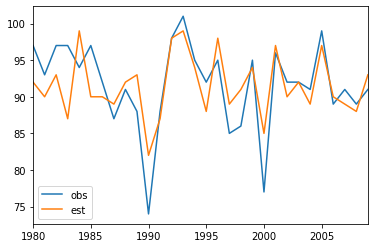

In [69]:
plot(met, years, cf_estimate, cf_params_de)

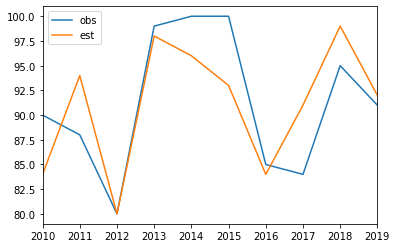

In [70]:
plot(met, testing_years, cf_estimate, cf_params_de)

### GDD vs. CF

#### Calibration Results

In [71]:
r_gd_de = residuals(met, obs, years, gdd_estimate, gdd_params_de)
r_cf_de = residuals(met, obs, years, cf_estimate, cf_params_de)
o = observes(years)

##### RMSE

In [72]:
rmse(r_gd_de)

5.2883519802171515

In [73]:
rmse(r_cf_de)

4.00832467081531

##### EF

In [74]:
ef(r_gd_de, o)

0.17983642347420914

In [75]:
ef(r_cf_de, o)

0.5288214018052071

#### Testing Results

Let's test (or validate) the models with a different dataset than the one used for calibration. Ideally, we need a completely independent dataset, but here we keep using the same dataset, but selecting years not seen for calibration.

In [76]:
testing_r_gd_de = residuals(met, obs, testing_years, gdd_estimate, gdd_params_de)
testing_r_cf_de = residuals(met, obs, testing_years, cf_estimate, cf_params_de)
testing_o = observes(testing_years)

##### RMSE

In [77]:
rmse(testing_r_gd_de)

9.257429448826494

In [78]:
rmse(testing_r_cf_de)

4.527692569068709

##### EF

In [79]:
ef(testing_r_gd_de, testing_o)

-0.8728146853146852

In [80]:
ef(testing_r_cf_de, testing_o)

0.5520104895104896

##### AIC

In [81]:
def aic(r, k):
    n = len(r)
    ssr = (r**2).sum()
    s2 = ssr / n
    L = (1 / np.sqrt(2*np.pi*s2))**n * np.exp(-ssr / (2*s2))
    return 2*k - 2*np.log(L)

Number of parameters for each model.

In [82]:
gd_k = 2
cf_k = 3

In [83]:
aic(testing_r_gd_de, gd_k)

76.8872989201308

In [84]:
aic(testing_r_cf_de, cf_k)

64.58301952553708

### UW Cherry Blossom

In [85]:
def read_cherry_uw():
    df = pd.read_excel(
        io='./Cherry_PBD.xls',
        sheet_name='UW',
    )
    s = df.set_index('year').stack()
    s.index.names = ['year', 'cultivar']
    s.name = 'bloom'
    df = s.reset_index()
    df['bloom'] = df.apply(lambda r: pd.datetime.strptime(f'{r.year}-{r.bloom}', '%Y-%j'), axis=1)
    df['station'] = 'UW'
    return df.set_index(['station', 'cultivar', 'year'])
cherry_uw = read_cherry_uw()

In [86]:
cherry_uw.tail()

bloom
station cultivar year           
UW      Yoshino  2015 2015-03-16
                 2016 2016-03-11
                 2017 2017-03-26
                 2018 2018-03-20
                 2019 2019-03-29

In [87]:
uw_obs = cherry_uw.loc['UW', 'Yoshino']['bloom']

We use weather records from SeaTac aiport to predict flowering on the UW campus. Data from Sandpoint station (94290) would have been a better choice, but unfortunately they were not available at the time of writing this notebook.

In [88]:
usa_ds3505_seatac = pd.read_hdf('./usa_ds3505_seatac.h5')
uw_met = usa_ds3505_seatac.loc[727930].resample('D').mean()
uw_met.index = uw_met.index.tz_localize(None)

In [89]:
uw_met.tail()

,tavg
timestamp,
2019-08-27,22.167778
2019-08-28,24.276250
2019-08-29,19.027917
2019-08-30,20.503283
2019-08-31,19.474412


In [90]:
uw_obs

year
1994   1994-04-02
1996   1996-04-15
2005   2005-03-31
2006   2006-04-13
2007   2007-04-10
2008   2008-04-10
2009   2009-04-17
2010   2010-04-03
2011   2011-04-13
2012   2012-04-02
2013   2013-04-03
2014   2014-03-21
2015   2015-03-16
2016   2016-03-11
2017   2017-03-26
2018   2018-03-20
2019   2019-03-29
Name: bloom, dtype: datetime64[ns]